# Compute Doppler from CW signal reflection

In [1]:
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp, correlate, correlation_lags, find_peaks, hilbert
from tqdm import tqdm

In [2]:
import astropy.units as u
from astropy.constants import c as speed_of_light
from astropy.coordinates import EarthLocation, get_moon, solar_system_ephemeris
from astropy.time import Time

In [3]:
from pathlib import Path
import wget

In [4]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
dwingeloo = EarthLocation(
    lat="52d48m43.27", lon="6d23m46.21", height=60, ellipsoid="WGS84"
)
radius_moon = 1737.4 * u.km
solar_system_ephemeris.set("de430");

In [6]:
def moon_distance(time, location=dwingeloo):
    """Compute moon distance from Dwingeloo to the surface of the Moon"""
    return get_moon(time, location=location).distance - radius_moon

In [7]:
def moon_doppler(time, location=dwingeloo, restfreq=434.210 * u.MHz):
    """Calculate the theoretical two-way Doppler to the Moon"""
    distances = moon_distance(time + [[[-1], [+1]]] * u.s, location=location)
    velocity = 2 * ((distances[:, 1] - distances[:, 0]) / (2 * u.s)).to(u.km / u.s)
    freq_to_vel = u.doppler_radio(restfreq)
    newfreq = velocity.to(u.MHz, equivalencies=freq_to_vel)
    return (newfreq - restfreq).to(u.Hz)[0]

In [8]:
fs = 2e6  # sampling rate

In [9]:
if not Path("data/camras-txrx-2021_10_05_14_26_57.chan00.iq").exists():
    Path("data").mkdir(exist_ok=True)
    wget.download("https://charon.camras.nl/public/lora/camras-txrx-2021_10_05_14_26_57.chan00.iq", out="data")

In [10]:
# read data file with CW
data = np.fromfile(
    "data/camras-txrx-2021_10_05_14_26_57.chan00.iq", dtype=np.complex64, count=-1
)
# center the CW around 0 Hz (signal was transmitted with a 210kHz offset)
freq_offset = -210e3
data *= np.exp(
    -1j * 2 * np.pi * (-freq_offset / fs) * (np.linspace(1, len(data), len(data)))
).T

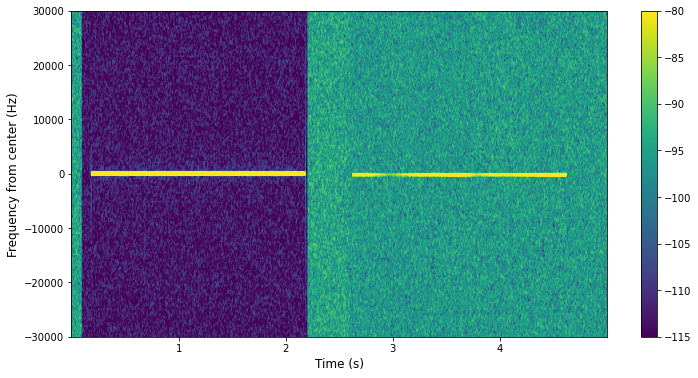

In [11]:
# show (zoomed) spectrogram of raw data
fig, ax0 = plt.subplots(figsize=(12, 6))
pxx, freq, t, cax = ax0.specgram(data, Fs=fs, NFFT=8 * 1024, clim=[-115, -80])
ax0.set_ylim([-30e3, 30e3])
ax0.set_xlabel("Time (s)")
ax0.set_ylabel("Frequency from center (Hz)")
fig.colorbar(cax);

In [12]:
_, echo = np.array_split(data, 2)

In [14]:
my_fft = np.fft.fftshift(np.fft.fft(np.hanning(len(echo)) * echo, 4 * 1048576))
# my_fft = np.fft.fftshift(np.fft.fft( echo, 4*1048576 ))

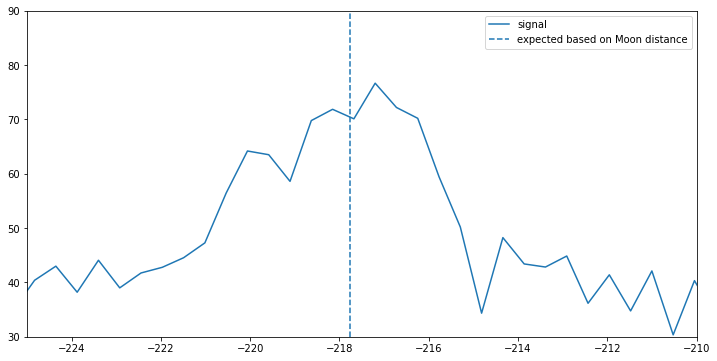

In [27]:
fig, ax0 = plt.subplots(figsize=(12, 6))
freq_offset = -1e6 + np.linspace(0, 2e6, len(my_fft))
ax0.plot(freq_offset, 20 * np.log10(np.abs(my_fft)), label="signal")
ax0.axvline(moon_doppler(Time("2021-10-05T12:26:57")).to(u.Hz).value, linestyle="--", label='expected based on Moon distance')
ax0.set_xlim([-225, -210])
ax0.legend(loc='upper right')
ax0.set_ylim([30, 90]);